In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
# import textblob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../topic_data.csv')

In [3]:
df_copy = df.copy()

In [4]:
df_copy.describe()

,raw_text_length,year,month,cleaned_text_length
count,4568.000000,4568.0,4568.000000,4568.000000
mean,27.330560,2023.0,3.703590,24.769483
std,11.840659,0.0,0.456724,11.581002
min,1.000000,2023.0,3.000000,1.000000
25%,17.000000,2023.0,3.000000,15.000000
50%,27.000000,2023.0,4.000000,24.000000
75%,37.000000,2023.0,4.000000,34.000000
max,61.000000,2023.0,4.000000,57.000000


In [5]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [6]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [7]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


Memory reduced from 3.2 --> 3.1 MB

**Preprocessing the data to obtain the tokens.**

- The cleaned_text version will be made use of for this process.

In [8]:
df_memory.sample(n=2,random_state=42)

,text,date,raw_text_length,year,month,cleaned_text,cleaned_text_length
1552,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15,2023,3,us sb real world ministry of truth being estab...,14
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20,2023,4,exclusive rep jeff van drew democrats afraid d...,17


In [9]:
featured_data = df_memory[['cleaned_text']]

In [10]:
featured_data

,cleaned_text
0,ah yes just love waking up to the sweet aroma...
1,when flies to georgia to take part in protest ...
2,exclusive rep jeff van drew democrats afraid o...
3,it april at pm stop your period pain instantly...
4,pmatcbidiamondjubilee corruption and dynastic...
...,...
4563,if the word cannot provoke you to preach the g...
4564,cept my own and that of the manager my name pr...
4565,graham potter chelsea exit set for huge impact...
4566,how to watch manchester united vs brentford us...


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

all_stopwords = STOP_WORDS
my_stop_words = set(all_stopwords) # My own stop words

In [12]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

featured_data['tokens'] = featured_data['cleaned_text'].apply(spacy_tokeniser)

In [13]:
# Compute bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser,ENGLISH_CONNECTOR_WORDS

In [14]:
docs = featured_data['tokens'].tolist()

In [15]:
# docs

In [16]:
docs[0][:8] # from document 1

['ah', 'yes', 'love', 'wake', 'sweet', 'aroma', 'political', 'chaos']

In [17]:
# Add bigrams to docs (only ones that appear 20 times or more).
# https://stackoverflow.com/questions/35716121/how-to-extract-phrases-from-corpus-using-gensim
# https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer
# This is usisng the default scorer and not the robust scorer; npmi
bigram_phrases = Phrases(docs, min_count=20,connector_words=ENGLISH_CONNECTOR_WORDS)

In [18]:
bigram = Phraser(bigram_phrases)

In [19]:
def make_bigram(texts):
    return([bigram[doc] for doc in texts])

In [20]:
bigrams_docs = make_bigram(docs)

In [21]:
print(bigrams_docs[200][:])

['exclusive_rep', 'jeff_van', 'draw_democrats', 'afraid_donald', 'trump_corruption', 'win']


In [22]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
id2word = Dictionary(bigrams_docs)
# or 
# dictionary = Dictionary(docs)


# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
id2word.filter_extremes(no_below=20, no_above=0.5)

In [23]:
# id2word.most_common(20) # most common words
# [('ai', 1005),
#  ('healthcare', 719),
#  ('usa', 594),
#  ('amp', 528),
#  ('corruption', 525),
#  ('truth', 516),
#  ('disaster', 455),
#  ('virus', 413),
#  ('manager', 387),
#  ('politic', 343),
#  ('football', 317),
#  ('new', 261),
#  ('world', 211),
#  ('like', 200),
#  ('people', 191),
#  ('trump', 186),
#  ('time', 182),
#  ('datum_science', 180),
#  ('machine_learn', 170),
#  ('win', 169)]

In [24]:
# Bag-of-words representation of the documents.
# Term document frequency 
bow_corpus = [id2word.doc2bow(doc) for doc in bigrams_docs]

In [25]:
# Create corpus
texts = bigrams_docs

In [26]:
print(f'Number of unique tokens: { len(id2word)}')
print(f'Number of documents: {len(bow_corpus)}')

Number of unique tokens: 629
Number of documents: 4568


In [27]:
featured_data.loc[200,"cleaned_text"]

'exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in '

In [28]:
# Verifying BOW is set up correctly
print(f" Cleaned Text: \n{featured_data.loc[200,'cleaned_text']}")
print(f"Bow representation: {bow_corpus[200]}")

document_200 = bow_corpus[200]
for i in range(len(document_200)):
    print(f"Word {document_200[i][0]}, {id2word[document_200[i][0]]}, appears {document_200[i][1]}")

 Cleaned Text: 
exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in 
Bow representation: [(10, 1), (11, 1), (12, 1), (40, 1), (45, 1), (46, 1)]
Word 10, draw_democrats, appears 1
Word 11, exclusive_rep, appears 1
Word 12, jeff_van, appears 1
Word 40, afraid_donald, appears 1
Word 45, trump_corruption, appears 1
Word 46, win, appears 1


### **Determining best number of topics**

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

In [30]:
def compute_coherence_scores(corpus,texts, dictionary,k,a=None,b=None):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            num_topics=k,
                                            id2word=dictionary,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,
                                            eval_every = None 
                                            # Don't evaluate model perplexity, takes too much time.
                                            )

    coherence_model_lda = CoherenceModel(model=lda_model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence="c_v",
                                        processes=-2)                            
                                                                    

    return coherence_model_lda.get_coherence()

In [31]:
model_results = {
    "topics": [],
    "coherence_score": [],
}

start = 2
stop = 10

In [32]:
# iterate through number of topics
for k in range(start,stop+1):
            score = compute_coherence_scores(corpus=bow_corpus,
                                            texts=texts,
                                        dictionary=id2word,
                                        k=k,
                                        )

            model_results["topics"].append(k) 
            model_results["coherence_score"].append(score) 

In [33]:
model_results_frame = pd.DataFrame(model_results)
model_results_frame.to_csv("model_versions/bigrams_results_cv.csv", index=False)

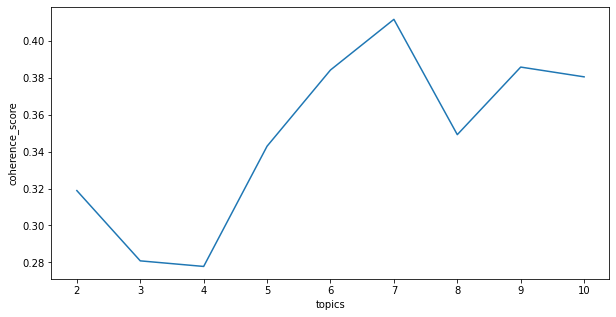

In [34]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=model_results_frame,x='topics',y="coherence_score")
plt.show()

In [35]:
zipped_values = zip(*model_results.values())
print(list(zipped_values))

[(2, 0.3188949572340618), (3, 0.28079275214389093), (4, 0.27776022007973844), (5, 0.3429731665114829), (6, 0.3842934262059416), (7, 0.4117607438647847), (8, 0.3492402460705338), (9, 0.3858805562994944), (10, 0.3805818079015115)]


In [36]:
coherence_scores = []
for topic, coherence_score in zip(*model_results.values()):
    print(f"Topic {topic} has a coherence_score of {coherence_score}")
    coherence_scores.append(coherence_score)

Topic 2 has a coherence_score of 0.3188949572340618
Topic 3 has a coherence_score of 0.28079275214389093
Topic 4 has a coherence_score of 0.27776022007973844
Topic 5 has a coherence_score of 0.3429731665114829
Topic 6 has a coherence_score of 0.3842934262059416
Topic 7 has a coherence_score of 0.4117607438647847
Topic 8 has a coherence_score of 0.3492402460705338
Topic 9 has a coherence_score of 0.3858805562994944
Topic 10 has a coherence_score of 0.3805818079015115


In [37]:
coherence_scores[np.argmax(coherence_scores,axis=0)]

0.4117607438647847

We would use 7 topics

In [38]:
optimal_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=7,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [39]:
# model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=50)

[(0,
  '0.114*"ai" + 0.085*"healthcare" + 0.016*"amp" + 0.015*"artificialintelligence" + 0.015*"technology" + 0.013*"industry" + 0.012*"future" + 0.012*"datum" + 0.012*"patient" + 0.011*"health" + 0.011*"care" + 0.011*"chatgpt" + 0.010*"healthtech" + 0.010*"innovation" + 0.010*"check" + 0.010*"read" + 0.009*"machinelearne" + 0.009*"tech" + 0.009*"improve" + 0.008*"change" + 0.008*"medical" + 0.008*"transform" + 0.007*"datascience" + 0.007*"tool" + 0.007*"digitalhealth" + 0.007*"gt_gt" + 0.007*"new" + 0.007*"update" + 0.006*"ai_ml" + 0.006*"artificial_intelligence" + 0.006*"way" + 0.006*"learn" + 0.006*"increase" + 0.006*"truth_social" + 0.006*"power" + 0.006*"provide" + 0.006*"potential" + 0.006*"period_pain" + 0.006*"obidatti_nigeriadecide" + 0.006*"experience_period" + 0.006*"gt_atikugate" + 0.006*"well_click" + 0.006*"instantly_naturally" + 0.006*"nuvapad_drug" + 0.006*"thepeoplestownhall" + 0.006*"iot" + 0.006*"help" + 0.006*"digital" + 0.005*"solution" + 0.005*"use"'),
 (1,
  '0.1

### **Visualising the topics**

In [40]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data = gensimvis.prepare(optimal_model,bow_corpus,id2word)
pyLDAvis.display(vis_data)


In [41]:
optimal_model_six = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=6,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [42]:
# model_topics = optimal_model.show_topics(formatted=False)
optimal_model_six.print_topics(num_words=50)

[(0,
  '0.104*"ai" + 0.077*"healthcare" + 0.018*"amp" + 0.016*"goal" + 0.015*"technology" + 0.014*"artificialintelligence" + 0.012*"industry" + 0.012*"future" + 0.011*"patient" + 0.010*"health" + 0.010*"datum" + 0.010*"care" + 0.010*"chatgpt" + 0.010*"healthtech" + 0.009*"innovation" + 0.009*"machinelearne" + 0.008*"tech" + 0.008*"medical" + 0.007*"gt_gt" + 0.007*"read" + 0.007*"transform" + 0.007*"change" + 0.007*"improve" + 0.006*"thank" + 0.006*"tool" + 0.006*"digitalhealth" + 0.006*"great" + 0.006*"digital" + 0.006*"datascience" + 0.006*"artificial_intelligence" + 0.006*"ai_ml" + 0.006*"learn" + 0.006*"increase" + 0.005*"truth_social" + 0.005*"impact" + 0.005*"new" + 0.005*"power" + 0.005*"education" + 0.005*"use" + 0.005*"blockchain" + 0.005*"article" + 0.005*"risk" + 0.005*"research" + 0.005*"well_click" + 0.005*"obidatti_nigeriadecide" + 0.005*"period_pain" + 0.005*"experience_period" + 0.005*"nuvapad_drug" + 0.005*"thepeoplestownhall" + 0.005*"instantly_naturally"'),
 (1,
  '0.

### **Visualising the topics**

In [43]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_six = gensimvis.prepare(optimal_model_six,bow_corpus,id2word)
pyLDAvis.display(vis_data_six)
